# Fig. 3

**Author**: laquitainesteeve@gmail using codes from Carlo Paris and Matthew Chalk

**Description**: Compute SSI and $I_{local}$ for models of RGCs responses to natural images reduced in 2D PC space (2D image tuning curves).

**Execution time**: 20 min (ngamma=100); convergence within 3 min with ngamma=20

## Setup 

Setup "_fisher_info_limits2_" virtual environment

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [1]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
from matplotlib import pyplot as plt;
import scipy.io as sio
import numpy as np
from numpy import log
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# import custom package
from src import nodes

# setup ilocal parmaeters
SEED = 10
ngamma = 100     # default=100;
gamma0 = 0.01
gamma_max = 200
eta = 1e-4
ny = 101         # discretisation of y = x + sqrt(gamma)*noise. Adapt depending on gamma and tuning curve discretization.
AMP = 20         # max possible spike count
NUM_X = 100      # number of points along each axis in the latent space grid
MAX_X = 10       # max value of PC1 and PC2 axes

# setup the data paths of four examples cells
# linear weak firing
CELL_DATA_PATH_CELL1 = 'data/contrast_cells/carlo_data_cellno104.mat'       # cell responses and image principal components
METRICS_DATA_PATH_CELL1 = 'data/computed_contrast_cells/BDEvSSI_no104.npz'  # precomputed information metrics

# linear strong firing
CELL_DATA_PATH_CELL2 = 'data/contrast_cells/carlo_data_cellno86.mat'       # cell responses and image principal components
METRICS_DATA_PATH_CELL2 = 'data/computed_contrast_cells/BDEvSSI_no86.npz'  # precomputed information metrics

# nonlinear weak firing
CELL_DATA_PATH_CELL3 = 'data/contrast_cells/carlo_data_cellno12.mat'       # cell responses and image principal components
METRICS_DATA_PATH_CELL3 = 'data/computed_contrast_cells/BDEvSSI_no12.npz'  # precomputed information metrics

# nonlinear strong firing
CELL_DATA_PATH_CELL4 = 'data/contrast_cells/carlo_data_cellno82.mat'       # cell responses and image principal components
METRICS_DATA_PATH_CELL4 = 'data/computed_contrast_cells/BDEvSSI_no82.npz'  # precomputed information metrics

# setup figure paraleters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

CPU times: user 3.49 s, sys: 133 ms, total: 3.62 s
Wall time: 1.04 s


## Functions

In [2]:
def plot_fig3_panel(fig, gs_main, rate_preds: np.array, ssi: np.array, Ilocal: np.array, 
                    pcs: np.array, sigma: np.array, grid_x: np.array, grid_y: np.array, 
                    xylim=(-3,3), xyticks=(-3,0,3), ngamma: int=20, letter='A'):
    """Plot Fig. 3 panel with 2D tuning curve, ssi and ilocal for a given cell.
    
    Args:
        fig: matplotlib figure object
        gs_main: gridspec object for the main panel
        rate_preds: 1D array of mean spike count predictions for each point on the latent space grid
        ssi: 2D array of stimulus-specific information over the latent space grid
        Ilocal: 2D array of local information over the latent space grid
        pcs: 2D array of image principal components (shape: num_images x 2)
        sigma: 2D array of Gaussian prior covariance matrix (shape: 2 x 2)
        grid_x: 2D array of x-coordinates of the latent space grid
        grid_y: 2D array of y-coordinates of the latent space grid
        xylim: tuple, limits for x and y axes
        xyticks: tuple, ticks for x and y axes
        ngamma: int, number of noise levels used in ilocal computation
    
    Returns:
        fig: matplotlib figure object with the plotted panel
    """ 
    # set figure parameters
    letter_size = 20
    letter_x = -0.5
    letter_y = 2

    # calculate the mean coordinates of the Gaussian prior
    mu0 = pcs[0].mean()
    mu1 = pcs[1].mean()

    # Create mask for 3 standard deviations
    mask_3std = nodes.create_gaussian_mask(grid_x, grid_y, np.array([mu0, mu1]), sigma, n_std=3)

    # Apply mask to data
    preds_masked = np.where(mask_3std, rate_preds.reshape(grid_x.shape), np.nan)
    ssi_masked = np.where(mask_3std, ssi, np.nan)
    Ilocal_masked = np.where(mask_3std, Ilocal, np.nan)

    # First subplot: Stimulus pcs & histogram --------------------------------------------------------------------------------
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 2,
                                            subplot_spec=gs_main[0],
                                            width_ratios=[4, 1],
                                            height_ratios=[1, 4],
                                            hspace=0.5, wspace=0.2)

    # create axes for the mosaic
    axs = {}
    axs['histx'] = fig.add_subplot(gs_top[0, 0])
    axs['scatter'] = fig.add_subplot(gs_top[1, 0])
    axs['histy'] = fig.add_subplot(gs_top[1, 1])

    # plot scatter points and histograms
    nodes.scatter_hist(pcs[0], pcs[1], axs['scatter'], axs['histx'], axs['histy'], c=(.7,0.7,0.7))
    axs['scatter'].set_aspect('equal')
    axs['scatter'].set_xlabel('Natural image PC1')
    axs['scatter'].set_ylabel('Natural image PC2')
    axs['scatter'].set_xlim(xylim)
    axs['scatter'].set_ylim(xylim)
    axs['scatter'].set_xticks(xyticks,xyticks)
    axs['scatter'].set_yticks(xyticks,xyticks)

    # plot prior (contours)
    for n_std in np.arange(0, 5, 1):
        nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                            axs['scatter'], n_std=n_std,
                            edgecolor='red', facecolor='None')

    # aesthetics
    axs['scatter'].spines[['top','right']].set_visible(False)
    axs['histx'].spines[['top','right']].set_visible(False)
    axs['histx'].set_ylabel('Count')
    axs['histy'].spines[['top','right']].set_visible(False)
    axs['histy'].set_xlabel('Count')
    axs['histx'].text(letter_x, letter_y, letter, transform=axs['scatter'].transAxes,
                fontsize=letter_size, fontweight='bold', va='top', ha='right')


    # Second subplot: Tuning curve and prior --------------------------------------------------------------------------------

    ax_bottom = fig.add_subplot(gs_main[1])

    # plot tuning curve as heatmap (MASKED - white outside 3 std)
    im = ax_bottom.contourf(grid_x, grid_y, preds_masked, levels=50, cmap='viridis', extend='neither')
    ax_bottom.set_facecolor('white')  # Set background to white for masked regions
    # colorbar
    divider = make_axes_locatable(ax_bottom)
    cax = divider.append_axes("right", size="10%", pad=0.3)
    cbar = plt.colorbar(im, cax=cax, label="mean spike count")
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks[::2])

    # plot prior as contours
    for n_std in np.arange(0, 6, 1):
        nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                            ax_bottom, n_std=n_std,
                            edgecolor='red', facecolor='None')

    # formatting
    ax_bottom.set_aspect('equal')
    ax_bottom.spines[['right']].set_visible(False)
    ax_bottom.set_xlabel("Natural image PC1")
    ax_bottom.set_ylabel("Natural image PC2")
    ax_bottom.set_xlim(xylim)
    ax_bottom.set_ylim(xylim)
    ax_bottom.set_xticks(xyticks,xyticks)
    ax_bottom.set_yticks(xyticks,xyticks)
    ax_bottom.spines[['top','right']].set_visible(False)

    # Third subplot: plot SSI (MASKED - white outside 3 std) ----------------------------------------------------

    ax_bottom3 = fig.add_subplot(gs_main[2])
    im = ax_bottom3.contourf(grid_x, grid_y, ssi_masked/log(2), levels=50, cmap='viridis', extend='neither')

    # formatting
    ax_bottom3.set_facecolor('white')  # Set background to white for masked regions
    ax_bottom3.set_xlim(xylim)
    ax_bottom3.set_ylim(xylim)
    ax_bottom3.set_xticks(xyticks,xyticks)
    ax_bottom3.set_yticks(xyticks,xyticks)
    # colorbar
    divider = make_axes_locatable(ax_bottom3)
    cax = divider.append_axes("right", size="10%", pad=0.3)
    cbar = plt.colorbar(im, cax=cax, label='SSI (bits)')
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks[::2])

    # plot prior as contours
    for n_std in np.arange(0, 6, 1):
        nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                            ax_bottom3, n_std=n_std,
                            edgecolor='red', facecolor='None')
    # formatting
    ax_bottom3.set_xlabel("Natural image PC1")
    ax_bottom3.set_ylabel("Natural image PC2")
    ax_bottom3.set_aspect('equal')
    ax_bottom3.spines[['top','right']].set_visible(False)

    # Get existing ticks


    # Fourth subplot: plot Ilocal (MASKED - white outside 3 std) ----------------------------------------------------
    ax_bottom3 = fig.add_subplot(gs_main[3])
    im = ax_bottom3.contourf(grid_x, grid_y, Ilocal_masked / log(2), levels=50, cmap='viridis', extend='neither')

    # formatting
    ax_bottom3.set_facecolor('white')  # Set background to white for masked regions
    ax_bottom3.set_xlim(xylim)
    ax_bottom3.set_ylim(xylim)
    ax_bottom3.set_xticks(xyticks,xyticks)
    ax_bottom3.set_yticks(xyticks,xyticks)
    # colorbar
    divider = make_axes_locatable(ax_bottom3)
    cax = divider.append_axes("right", size="10%", pad=0.3)
    cbar = plt.colorbar(im, cax=cax, label='$I_{local}$ (bits)')
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks[::2])

    # plot prior as contours
    for n_std in np.arange(0, 6, 1):
        nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                            ax_bottom3, n_std=n_std,
                            edgecolor='red', facecolor='None')
    # formatting
    ax_bottom3.set_xlabel("Natural image PC1")
    ax_bottom3.set_ylabel("Natural image PC2")
    ax_bottom3.set_aspect('equal')
    ax_bottom3.spines[['top','right']].set_visible(False)

    # format figure
    fig.subplots_adjust(wspace=0.9, hspace=0.5)
    return fig

## Load dataset

In [3]:
%%time

np.random.seed(SEED)

# load the data and parameters of the image prior for cell 1
pcs_cell1, fit_cell1, mu0_cell1, mu1_cell1, sigma_cell1 = nodes.load_cell_data(CELL_DATA_PATH_CELL1)

# load the data and parameters of the image prior for cell 2
pcs_cell2, fit_cell2, mu0_cell2, mu1_cell2, sigma_cell2  = nodes.load_cell_data(CELL_DATA_PATH_CELL2)

# load the data and parameters of the image prior for cell 3
pcs_cell3, fit_cell3, mu0_cell3, mu1_cell3, sigma_cell3  = nodes.load_cell_data(CELL_DATA_PATH_CELL3)

# load the data and parameters of the image prior for cell 4
pcs_cell4, fit_cell4, mu0_cell4, mu1_cell4, sigma_cell4  = nodes.load_cell_data(CELL_DATA_PATH_CELL4)

# all prior means are near 0, so we set the prior means to (0,0) for all cells
print("prior mean cell 1:", (mu0_cell1, mu1_cell1))
print("prior mean cell 2:", (mu0_cell2, mu1_cell2))
print("prior mean cell 3:", (mu0_cell3, mu1_cell3))
print("prior mean cell 4:", (mu0_cell4, mu1_cell4))

prior mean cell 1: (np.float64(0.0), np.float64(1.798842369012912e-17))
prior mean cell 2: (np.float64(-4.49710592253228e-18), np.float64(2.24855296126614e-18))
prior mean cell 3: (np.float64(-2.1361253132028328e-17), np.float64(1.3491317767596838e-17))
prior mean cell 4: (np.float64(-4.2708990760651386e-17), np.float64(5.3948198855559645e-17))
CPU times: user 3.25 s, sys: 319 ms, total: 3.57 s
Wall time: 3.57 s


## Model tuning curves

In [4]:
%%time

# setup the image latent space
pc_values = np.linspace(-MAX_X, MAX_X, NUM_X) # the values each axis (PC1 and PC2) can take

# train a neural net to predict cells responses in that latent space
# cell 1
_, tuning_curve_model_cell1, _, grid_x, grid_y, _, latent_space = nodes.nnet_fit(pcs_cell1[:2], fit_cell1, linspace=pc_values)

# cell 2
tuning_curve_model_cell2 = nodes.nnet_fit(pcs_cell2[:2], fit_cell2, linspace=pc_values)[1]

# cell 3
tuning_curve_model_cell3 = nodes.nnet_fit(pcs_cell3[:2], fit_cell3, linspace=pc_values)[1]

# cell 4
tuning_curve_model_cell4 = nodes.nnet_fit(pcs_cell4[:2], fit_cell4, linspace=pc_values)[1]

Epoch 1/200, Train Loss: 1.7561, Val Loss: 1.5653
Epoch 20/200, Train Loss: 0.5288, Val Loss: 0.4762
Epoch 40/200, Train Loss: 0.1342, Val Loss: 0.1258
Epoch 60/200, Train Loss: 0.0767, Val Loss: 0.0753
Epoch 80/200, Train Loss: 0.0602, Val Loss: 0.0556
Epoch 100/200, Train Loss: 0.0565, Val Loss: 0.0513
Epoch 120/200, Train Loss: 0.0553, Val Loss: 0.0500
Epoch 140/200, Train Loss: 0.0544, Val Loss: 0.0492
Epoch 160/200, Train Loss: 0.0537, Val Loss: 0.0486
Epoch 180/200, Train Loss: 0.0530, Val Loss: 0.0481
Epoch 200/200, Train Loss: 0.0524, Val Loss: 0.0476
Epoch 1/200, Train Loss: 7.5002, Val Loss: 6.0573
Epoch 20/200, Train Loss: 5.2627, Val Loss: 4.0370
Epoch 40/200, Train Loss: 3.7599, Val Loss: 2.7899
Epoch 60/200, Train Loss: 2.9203, Val Loss: 2.1602
Epoch 80/200, Train Loss: 2.3692, Val Loss: 1.7232
Epoch 100/200, Train Loss: 1.9117, Val Loss: 1.3535
Epoch 120/200, Train Loss: 1.5588, Val Loss: 1.0922
Epoch 140/200, Train Loss: 1.2958, Val Loss: 0.9126
Epoch 160/200, Train Los

## Compute SSI

Execution time: 0.3 secs

In [5]:
%%time 

# cell 1
rate_preds_cell1 = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell1).reshape(NUM_X, NUM_X)
ssi_cell1, Inf_ssi_cell1 = nodes.compute_ssi(latent_space, rate_preds_cell1, amp=AMP, Sigmax=sigma_cell1)[:2]

# cell 2
rate_preds_cell2 = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell2).reshape(NUM_X, NUM_X)
ssi_cell2, Inf_ssi_cell2 = nodes.compute_ssi(latent_space, rate_preds_cell2, amp=AMP, Sigmax=sigma_cell2)[:2]

# cell 3
rate_preds_cell3 = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell3).reshape(NUM_X, NUM_X)
ssi_cell3, Inf_ssi_cell3 = nodes.compute_ssi(latent_space, rate_preds_cell3, amp=AMP, Sigmax=sigma_cell3)[:2]

# cell 4
rate_preds_cell4 = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell4).reshape(NUM_X, NUM_X)
ssi_cell4, Inf_ssi_cell4 = nodes.compute_ssi(latent_space, rate_preds_cell4, amp=AMP, Sigmax=sigma_cell4)[:2]

CPU times: user 543 ms, sys: 23.1 ms, total: 566 ms
Wall time: 33.2 ms


## Compute $I_{local}$

Execution time: 1h20 min

In [ ]:
# cell 1
Ilocal_cell1, Inf_cell1, gamma = nodes.compute_ilocal(latent_space, tuning_curve_model_cell1, sigma_cell1, ny, ngamma, gamma0, gamma_max, eta, AMP)

# cell 2
Ilocal_cell2, Inf_cell2, gamma = nodes.compute_ilocal(latent_space, tuning_curve_model_cell2, sigma_cell2, ny, ngamma, gamma0, gamma_max, eta, AMP)

# cell 3
Ilocal_cell3, Inf_cell3, gamma = nodes.compute_ilocal(latent_space, tuning_curve_model_cell3, sigma_cell3, ny, ngamma, gamma0, gamma_max, eta, AMP)

# cell 4
Ilocal_cell4, Inf_cell4, gamma = nodes.compute_ilocal(latent_space, tuning_curve_model_cell4, sigma_cell4, ny, ngamma, gamma0, gamma_max, eta, AMP)

Computing ilocal:  76%|███████▌  | 76/100 [12:33<04:06, 10.27s/it]

5.693531414280075
5.684532204036557
5.286595374248814
4.9411791513148025


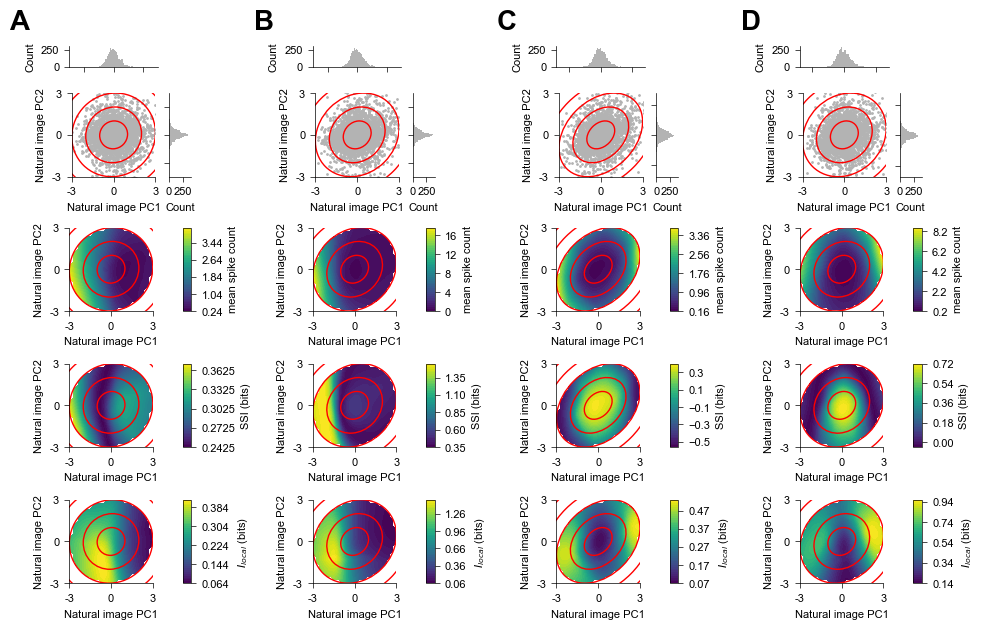

In [ ]:
# setup figure parameters
fig_params = {'grid_x': grid_x, 'grid_y': grid_y, 'ngamma': ngamma, 'xylim': (-3,3), 'xyticks': (-3,0,3)}

# setup figure
fig = plt.figure(figsize=(11, 7))

# create main GridSpec: 1 col, 3 rows
gs_main = gridspec.GridSpec(4, 4, figure=fig, wspace=1, hspace=0.5, height_ratios=[1.5,1,1,1])

# cell 1
gs_cell1 = [gs_main[i,0] for i in range(4)]
fig = plot_fig3_panel(fig, gs_cell1, rate_preds_cell1, ssi_cell1, Ilocal_cell1, pcs_cell1, sigma_cell1, letter='A', **fig_params)

# cell 2
gs_cell2 = [gs_main[i,1] for i in range(4)]
fig = plot_fig3_panel(fig, gs_cell2, rate_preds_cell2, ssi_cell2, Ilocal_cell2, pcs_cell2, sigma_cell2, letter='B',**fig_params)

# cell 3
gs_cell3 = [gs_main[i,2] for i in range(4)]
fig = plot_fig3_panel(fig, gs_cell3, rate_preds_cell3, ssi_cell3, Ilocal_cell3, pcs_cell3, sigma_cell3, letter='C',**fig_params)

# cell 4
gs_cell4 = [gs_main[i,3] for i in range(4)]
fig = plot_fig3_panel(fig, gs_cell4, rate_preds_cell4, ssi_cell4, Ilocal_cell4, pcs_cell4, sigma_cell4, letter='D',**fig_params)

# save figure
plt.savefig(f'figures/fig3.svg', bbox_inches = 'tight', transparent=True, dpi=400)
plt.savefig(f'figures/fig3.pdf', bbox_inches = 'tight', transparent=True, dpi=400)

## Control $I_{local}$

CPU times: user 30 ms, sys: 36 µs, total: 30 ms
Wall time: 29.7 ms


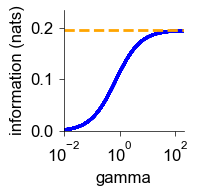

In [ ]:
%%time 

igamma = len(gamma)

# plot convergence
plt.figure(2, figsize=(2,2))

# plt.semilogx(gamma[:igamma], Inf[:igamma], 'b-', linewidth=2, label='plug in')
plt.semilogx(gamma[:igamma], Inf_cell1[:igamma], 'b-', linewidth=2, label='plug in')

plt.axhline(Inf_ssi_cell1, color='orange', linestyle='--', linewidth=2, 
            label=r'$\int_0^\gamma \langle I_{\gamma}(x)\rangle_{p(x)} d\gamma$')

plt.xlabel('gamma', fontsize=12)
plt.ylabel('information (nats)', fontsize=12)
plt.ylim([0, 1.2 * Inf_ssi_cell1])
plt.xlim([gamma[0], gamma[igamma-1]])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tick_params(labelsize=12)
plt.tight_layout()
# # 
# plt.savefig(f'figures/fig3_info_converg_ngamma_{ngamma}.svg', bbox_inches = 'tight', transparent=True, dpi=400)
# plt.savefig(f'figures/fig3_info_converg_ngamma_{ngamma}.pdf', bbox_inches = 'tight', transparent=True, dpi=400)